Dallas County Animal Shelter Data Analysis on Cats and Dogs from 2023 - 2025 

Step 1: Import Required Packages

In [19]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt 

Step 2: Load Data Sample from Website

In [20]:
url = "https://www.dallasopendata.com/resource/uyte-zi7f.json"

def fetch_shelter_data(limit=95000):
    params = {"$limit": limit}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data)
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()
    
df_raw = fetch_shelter_data()
print(f"Data retrieved: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print(df_raw.head())

Data retrieved: 90873 rows, 33 columns
  animal_id animal_type animal_breed kennel_number kennel_status  \
0  A0011910         DOG     PIT BULL     RESC FOST   UNAVAILABLE   
1  A0011910         DOG     PIT BULL         DC 24     AVAILABLE   
2  A0178985         DOG   ROTTWEILER          2708           LAB   
3  A0180810         DOG  MIXED BREED           G05     AVAILABLE   
4  A0180810         DOG  MIXED BREED           G05     AVAILABLE   

  activity_number activity_sequence source_id census_tract council_district  \
0      A23-412044                 1  P9998533         4900                4   
1      A23-412044                 1  P0737656          NaN              NaN   
2      A24-443161                 1  P1096837         8701                4   
3             NaN                 1  P0886821         4000                7   
4             NaN                 1  P1112628          NaN              NaN   

   ... outcome_time impound_number outcome_condition   chip_status  \
0  ... 

Step 3: Dataset Overview - Display Basic Information About the Dataset to Prepare for Cleaning and Analysis

In [21]:
print(f"Dataset shape: {df_raw.shape}")

print("\nFirst few rows:")
print(df_raw.head())

# Check for missing values
print("\nMissing values per column:")
print(df_raw.isnull().sum())

# Check possible values for outcome_type
print("\nUnique outcome_type values found in data:")
print(df_raw["outcome_type"].unique())
print("-" * 30)

# Check possible values for intake_type
print("\nUnique intake_type values found in data:")
print(df_raw["intake_type"].unique())
print("-" * 30)

Dataset shape: (90873, 33)

First few rows:
  animal_id animal_type animal_breed kennel_number kennel_status  \
0  A0011910         DOG     PIT BULL     RESC FOST   UNAVAILABLE   
1  A0011910         DOG     PIT BULL         DC 24     AVAILABLE   
2  A0178985         DOG   ROTTWEILER          2708           LAB   
3  A0180810         DOG  MIXED BREED           G05     AVAILABLE   
4  A0180810         DOG  MIXED BREED           G05     AVAILABLE   

  activity_number activity_sequence source_id census_tract council_district  \
0      A23-412044                 1  P9998533         4900                4   
1      A23-412044                 1  P0737656          NaN              NaN   
2      A24-443161                 1  P1096837         8701                4   
3             NaN                 1  P0886821         4000                7   
4             NaN                 1  P1112628          NaN              NaN   

   ... outcome_time impound_number outcome_condition   chip_status  \
0 

Step 4: Clean and Filter Data for Analysis 

In [22]:
df = df_raw.copy() # Creates a copy of the data to work with

# Convert income/outcome date columns to pandas datetime objects for future analysis
date_cols = ["intake_date", "outcome_date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce") # Use errors='coerce' in case of missing data or typos

# Drop rows where critical data is missing
df.dropna(
    subset=[
        "outcome_type",
        "intake_date",
        "outcome_date",
        "animal_breed",
        "intake_condition",
        "animal_type",
    ],
    inplace=True,
)

# Filter for only cats and dogs
df = df[df["animal_type"].isin(["CAT", "DOG"])]

# Exclude animals that are deceased on arrival
df = df[df["intake_condition"] != "DECEASED"]

# Exclude animals with intake_type of treatment and resource that are not being housed at the shelter
df = df[~df["intake_type"].isin(["TREATMENT", "RESOURCE"])]

# Calculate length of stay
df["length_of_stay_days"] = (df["outcome_date"] - df["intake_date"]).dt.days

# Define Live Release categories (using outcome_type values)
live_release_types = [
    "ADOPTION",
    "RETURNED TO OWNER",
    "TRANSFER",
    "FOSTER",
    "TNR",
]

# Create a new outcome_group column
df["outcome_group"] = df["outcome_type"].apply(
    lambda x: "Live Release"
    if x in live_release_types
    else ("Deceased" if x == "EUTHANIZED" or x == "DIED" else "Other/Unknown")
)

# Filter out Other/Unknown outcomes for this specific analysis
df = df[df["outcome_group"].isin(["Live Release", "Deceased"])]

print("\nFinal Output:")
print(df["outcome_group"].value_counts())
print(df["intake_condition"].value_counts())


Final Output:
outcome_group
Live Release    61080
Deceased         8174
Name: count, dtype: int64
intake_condition
APP WNL      57140
APP SICK      4334
APP INJ       3694
UNDERAGE      2417
CRITICAL      1500
GERIATRIC      148
FATAL           21
Name: count, dtype: int64


Step 5: Data Analysis and Visualizations

Overall Outcome Group Distribution - This is the overall percentage of cats and dogs with a live release outcome vs. a deceased outcome

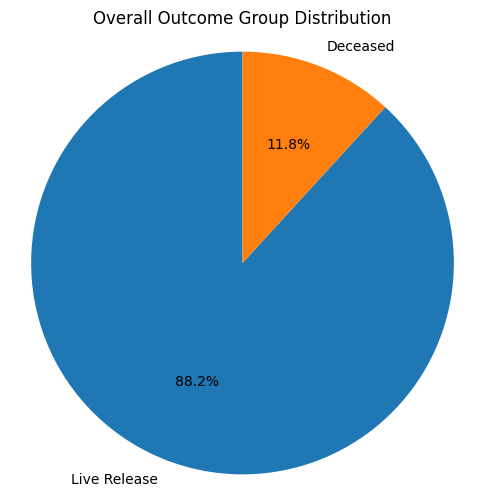

In [23]:
# Calculate the counts for each outcome group
counts = df["outcome_group"].value_counts()

# Pull the labels
labels = counts.index

# Use counts for size
sizes = counts.values

# Plot results as a pie chart
plt.figure(
    figsize=(6, 6)
)  # Optional: Adjusts the size of the plot for better visibility

plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",  # Display percentages 
    startangle=90,  
)
plt.axis("equal")
plt.title("Overall Outcome Group Distribution")
plt.savefig("outcome_group_pie_chart.png")
plt.show()

Factors Affecting Outcome Group - Do specific factors, such as the type of animal or the different ways an animal enters the shelter, affect the outcome for cats and dogs?

1. Animal Type Vs. Outcome Group - Does the type of animal have an affect on the outcome?


Percentage Outcomes by Animal Type:
 outcome_group  Deceased  Live Release
animal_type                          
CAT               14.25         85.75
DOG               10.57         89.43


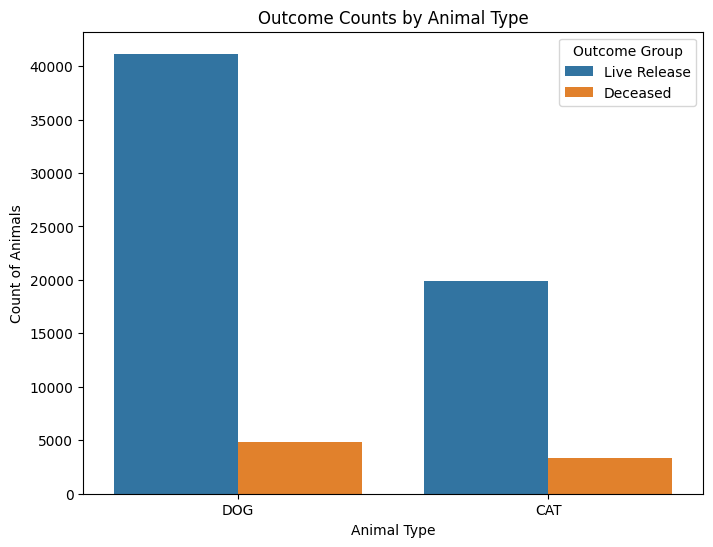

In [24]:
ct_animal_type = (
    pd.crosstab(df["animal_type"], df["outcome_group"], normalize="index") * 100
)
print("\nPercentage Outcomes by Animal Type:\n", ct_animal_type.round(2))

# Create a bar graph of Animal Type vs. Outcome Group
plt.figure(figsize=(8, 6))
sns.countplot(x="animal_type", hue="outcome_group", data=df)

plt.title("Outcome Counts by Animal Type")
plt.xlabel("Animal Type")
plt.ylabel("Count of Animals")
plt.legend(title="Outcome Group")
plt.savefig("animal_type_vs_outcome.png")
plt.show()

2. Intake Condition Vs. Outcome - Does the condition an animal arrives in affect the outcome?


Percentage Outcomes by Intake Condition:
 outcome_group     Deceased  Live Release
intake_condition                        
APP INJ              38.14         61.86
APP SICK             37.10         62.90
APP WNL               6.04         93.96
CRITICAL             76.27         23.73
FATAL               100.00          0.00
GERIATRIC            55.41         44.59
UNDERAGE             18.95         81.05


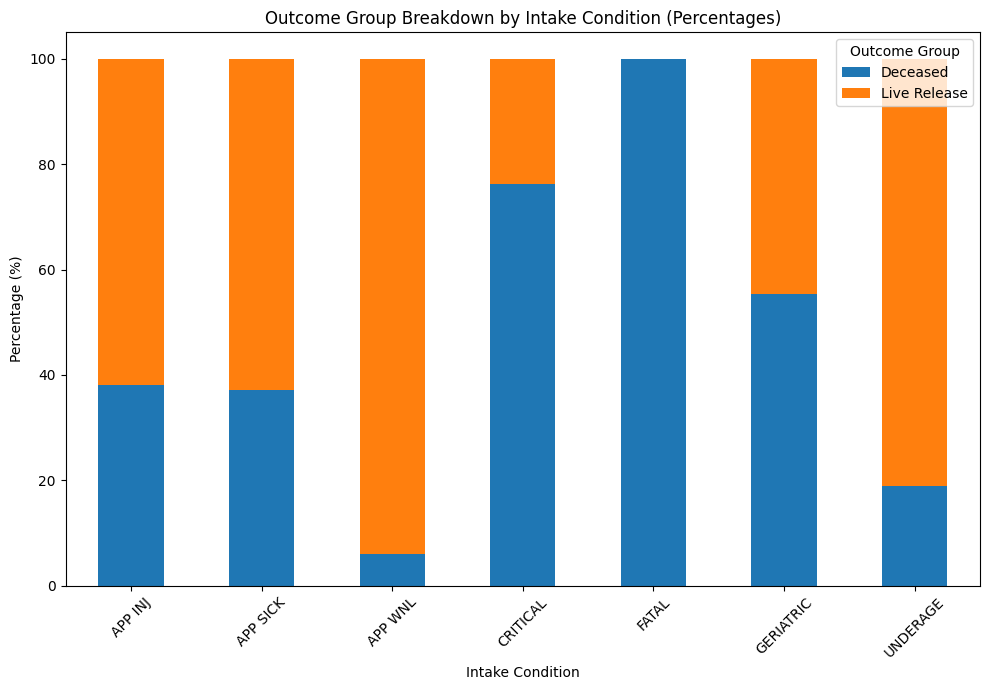

In [25]:
ct_intake_condition = (
    pd.crosstab(df["intake_condition"], df["outcome_group"], normalize="index") * 100
)
print("\nPercentage Outcomes by Intake Condition:\n", ct_intake_condition.round(2))

# Create stacked bar chart
ct_intake_condition.plot(kind="bar", stacked=True, figsize=(10, 7), rot=45)

plt.title("Outcome Group Breakdown by Intake Condition (Percentages)")
plt.xlabel("Intake Condition")
plt.ylabel("Percentage (%)")
plt.legend(title="Outcome Group")
plt.tight_layout()
plt.savefig("intake_condition_vs_outcome.png")
plt.show()

Intake Type Vs. Length of Stay - Does the type of intake affect how long an animal remains in the shelter?

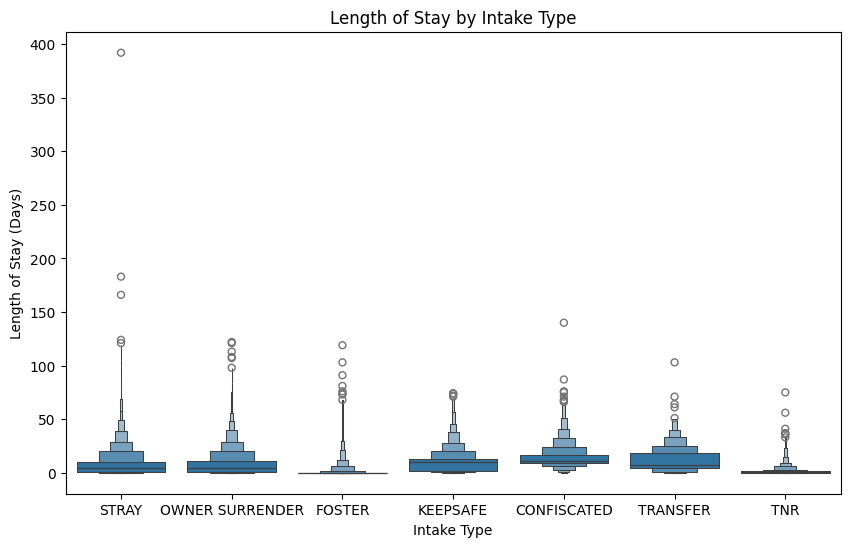

In [26]:
plt.figure(figsize=(10, 6))
sns.boxenplot(x="intake_type", y="length_of_stay_days", data=df)

plt.title("Length of Stay by Intake Type")
plt.xlabel("Intake Type")
plt.ylabel("Length of Stay (Days)")
plt.savefig("los_by_intake.png")
plt.show()

Seasonality Trends in Intake - Does the data reflect expected seasonal trends in intakes (such as increased intakes during summer months for "kitten season")?

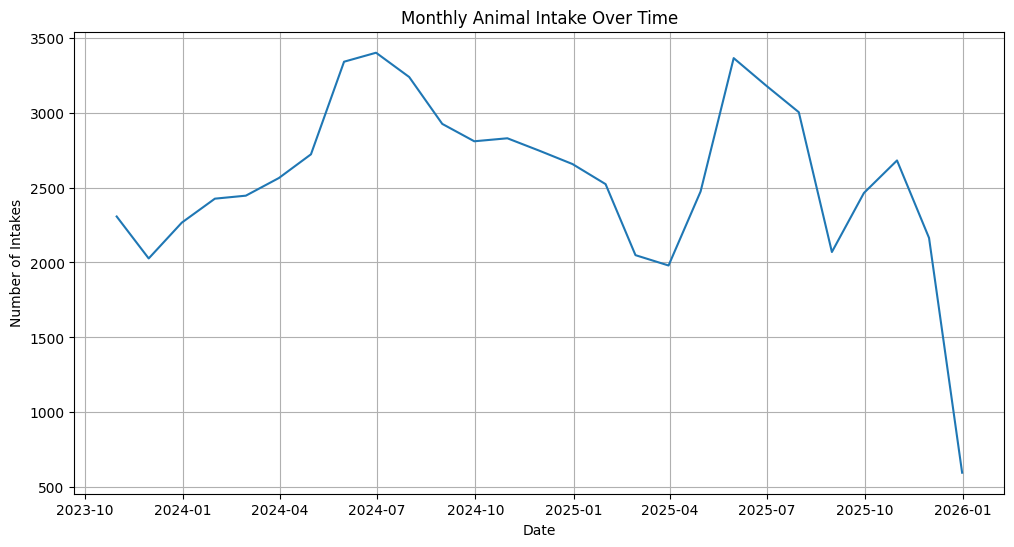

In [27]:
df_time = df.set_index("intake_date")
monthly_intakes = df_time.resample("ME").size() # Resample the data by month and count the number of intakes for the month

# Convert back into a Dataframe
intake_trends = monthly_intakes.to_frame(name="Intake Count").reset_index()

# Create line graph of Monthly Intakes Over Time
plt.figure(figsize=(12, 6))

sns.lineplot(data=intake_trends, x="intake_date", y="Intake Count")

plt.title("Monthly Animal Intake Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Intakes")
plt.grid(True)  # Add a grid to better visualize
plt.savefig("monthly_intakes_over_time.png")
plt.show()